# 2 - Genotyping quality control and Principal Component Analysis (PCA) computation

In [1]:
from matplotlib_venn import venn3
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import subprocess
import math
import sys
import os

## Introduction

During this preprocessing step, we perform quality control (QC) on merged genotyping data. QC is a fundamental step of every GWAS attempting to associate genetic variants to the studied trait. Since raw genotyping data contains errors, without QC the GWAS analysis would not return reliable results. Errors in genotyping data can have different sources, such as contaminations, poor quality of DNA samples or poor hybridization on the genotyping array.

During this phase we filter genotyping data for:
- **sex discrepancies**
- **SNPs with A/T and C/G**
- **SNP missingness rate**
- **genotyping missingness rate**
- **minor allele frequency (MAF)**
- **deviations from Hardy-weinberg equilibrium (HWE)**

After QC, we compute the PCA for genotyping data and plot the results.

In [2]:
ppmi_merge_fn = "../../data/genotyping/PPMI_merge"
ppmi_merge_bim_fn = "../../data/genotyping/PPMI_merge.bim"

### Exploring the merged SNP dataset

In [3]:
ppmi_merge_bim = pd.read_csv(ppmi_merge_bim_fn, sep="\t", header=None)
ppmi_merge_bim.head(n=10)

,0,1,2,3,4,5
0,1,NeuroX_PARK7_Pro158del,0,0,0,I
1,1,NeuroX_PINK1_23bp_del_ex7,0,0,0,I
2,1,NeuroX_PINK1_534_535insQ,0,0,0,D
3,1,NeuroX_PINK1_Asp525fs,0,0,0,D
4,1,NeuroX_PINK1_Cys549fs,0,0,0,I
5,1,NeuroX_PINK1_Lys520fs,0,0,0,I
6,1,exm2268640,0,762320,T,C
7,1,exm41,0,861349,0,C
8,1,exm1916089,0,865545,0,0
9,1,exm44,0,865584,0,G


## Quality Control

### Subject-level QC

As first step of QC, we remove subjects where provided sex information does not match the genotype inferred sex.

In [4]:
!plink --bfile {ppmi_merge_fn} --check-sex --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --check-sex
  --out ../../data/genotyping/PPMI_merge

16384 MB RAM detected; reserving 8192 MB for main workspace.
457171 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 520 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge.hh ); many commands treat these as missing.
treat these as missing.
Total genotyping rate is 0.95703.
457171 variants and 520 people pass filte

Plink detected 12 "problems". Let's retrieve those subjects and store their IIDs and FIDs in a file named ```remove_subjects.txt```.

In [5]:
remove_subjects = "../../data/genotyping/remove_subjects.txt"
checksex = pd.read_csv("".join([ppmi_merge_fn, ".sexcheck"]), sep="\s+")
checksex[checksex["STATUS"] == "PROBLEM"].iloc[:, [0,1]].to_csv(remove_subjects, header=False, index=False, sep=" ")

We can now remove these subjects. Moreover, we remove those subjects with 50% of genotype missing rate.

In [6]:
!plink --bfile {ppmi_merge_fn} --remove {remove_subjects} --mind 0.5 --make-bed --out {"_".join([ppmi_merge_fn, "subjQC"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge
  --make-bed
  --mind 0.5
  --out ../../data/genotyping/PPMI_merge_subjQC
  --remove ../../data/genotyping/remove_subjects.txt

16384 MB RAM detected; reserving 8192 MB for main workspace.
457171 variants loaded from .bim file.
520 people (341 males, 179 females) loaded from .fam.
--remove: 508 people remaining.
0 people removed due to missing genotype data (--mind).
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../dat

### SNP-level QC

Now that our data are OK at subject-level, we can proceed with a SNP-level QC.

We start by searching and removing the A/T and C/G SNPs. 

In [7]:
bad1 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'A') & (ppmi_merge_bim.iloc[:,5] == 'T')]
bad2 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'T') & (ppmi_merge_bim.iloc[:,5] == 'A')]
bad3 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'C') & (ppmi_merge_bim.iloc[:,5] == 'G')]
bad4 = ppmi_merge_bim[(ppmi_merge_bim.iloc[:,4] == 'G') & (ppmi_merge_bim.iloc[:,5] == 'C')]

badSnps = pd.concat([bad1, bad2, bad3, bad4])
badSnps_set = set(badSnps.iloc[:,1].values.tolist())

badsnps_fn = "../../data/genotyping/badsnps.txt"
pd.DataFrame(list(badSnps_set)).to_csv(badsnps_fn, header=False, index=False)

We have 34,510 A/T or C/G SNPs to remove. Parkinson's disease SNP biomarkers have been shown to reside on autosomal chromosomes. Thus, we also restrict our ananlysis to autosomal chromosomes.

In [8]:
ppmi_merge_fn = "_".join([ppmi_merge_fn, "subjQC"])

In [9]:
!plink --bfile {ppmi_merge_fn} --exclude {badsnps_fn} --make-bed --out {"_".join([ppmi_merge_fn, "snpQC"])}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC
  --exclude ../../data/genotyping/badsnps.txt
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

16384 MB RAM detected; reserving 8192 MB for main workspace.
457171 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
--exclude: 422661 variants remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
../../data/genotyping/PPMI_merge_subjQC_snpQC.hh ); many com

Since PD-related geentic variants are mainly located on autosomal and mithocondrial chromosomes, we remove the SNPs mapped on chrX, chrY and on pseudo autosomal regions of chrX.

We recall that the autosomes are coded 1 through 22. While the following other codes are used to specify other chromosome types:
- X  -- 23
- Y  -- 24
- XY -- 25
- MT -- 26

Let's exclude features mapped in 23, 24 and 25.

In [10]:
ppmi_merge_fn = "_".join([ppmi_merge_fn, "snpQC"])

In [11]:
!plink --bfile {ppmi_merge_fn} --not-chr 23,24,25 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --make-bed
  --not-chr 23,24,25
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

16384 MB RAM detected; reserving 8192 MB for main workspace.
filenames.
413354 out of 422661 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.955393.
413354 variants and 508 people pass filters and QC.
Note:

Now, we can filter those SNPs with a genotyping missingness rate of 10%.

In [12]:
!plink --bfile {ppmi_merge_fn} --geno 0.1 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --geno 0.1
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

16384 MB RAM detected; reserving 8192 MB for main workspace.
filenames.
413354 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.955393.
20955 variants removed due to missing genotype data (--geno).
392399 variants a

Plink removed 20,955 SNPs with a genotyping missingness rate of 10%.

Now, we filter SNP dataset by remove those SNPs with MAF < 5%.

In [13]:
!plink --bfile {ppmi_merge_fn} --maf 0.05 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --maf 0.05
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

16384 MB RAM detected; reserving 8192 MB for main workspace.
filenames.
392399 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.997877.
263340 variants removed due to minor allele threshold(s)
(--maf/--max-maf/--mac

Now we remove those SNPs deviating from HWE.

In [14]:
!plink --bfile {ppmi_merge_fn} --hwe 1e-06 --make-bed --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --hwe 1e-06
  --make-bed
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC

16384 MB RAM detected; reserving 8192 MB for main workspace.
filenames.
129059 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996572.
--hwe: 247 variants removed due to Hardy-Weinberg exact test.
128812 variants 

At the end we have 128,812 SNPs which passed all QC steps.

## Principal Component Analysis (PCA) computation

During this step we compute the first 20 Principal Components (PCs) of the relatedness matrix. This will help us to explore the genetic structure of the population analyzed.

In [15]:
!plink --bfile {ppmi_merge_fn} --pca 20 --out {ppmi_merge_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_merge_subjQC_snpQC.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --out ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 508 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996624.
128812 variants and 508 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calcula

Let's explore the computed PCs.

In [16]:
ppmi_pca = pd.read_csv(".".join([ppmi_merge_fn, "eigenvec"]), sep=' ', header=None)

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_pca.columns = cnames
ppmi_pca.head(n=15)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.009711,-0.018291,-0.006058,0.002939,0.065272,-0.001394,-0.011362,-0.058289,...,-0.029508,0.001343,-0.011889,-0.043342,-0.017034,-0.000299,0.045803,0.101191,-0.014988,0.045173
1,3001,3001,0.010701,-0.009840,0.015925,0.008439,-0.036720,0.041435,-0.045318,-0.012589,...,0.039496,-0.093732,-0.083821,-0.048282,0.062568,0.058528,0.055110,0.006319,0.027326,0.012470
2,3002,3002,0.010392,0.081568,-0.026678,-0.014991,-0.002337,-0.025038,-0.002785,0.012703,...,-0.008942,-0.000268,-0.026191,0.006963,-0.008400,-0.058635,0.028230,0.055682,0.072484,0.030029
3,3004,3004,0.015014,-0.023698,0.014627,-0.019912,-0.011551,0.021895,0.006360,-0.115199,...,0.007800,-0.023925,0.018885,0.036453,-0.057298,0.027147,0.021115,0.065936,0.131809,0.002048
4,3006,3006,0.014774,-0.009399,0.057317,0.080115,0.042520,0.007801,-0.036297,-0.036565,...,0.036173,-0.037863,0.003993,-0.025433,0.019231,0.007421,-0.001274,0.057294,-0.067048,0.051122
5,3008,3008,0.006309,-0.013975,-0.009787,-0.061537,0.021103,0.052570,0.031477,0.032635,...,0.016875,-0.027535,0.033296,0.105183,-0.008481,0.071918,-0.013721,-0.014612,-0.032518,0.051799
6,3009,3009,-0.269521,0.017724,0.024009,0.013818,0.015107,-0.027086,-0.049051,-0.036173,...,-0.025597,-0.028093,-0.038103,0.010995,-0.009459,-0.010340,0.005520,-0.011126,0.037388,-0.019451
7,3011,3011,0.016520,0.037783,0.017967,0.000313,0.043446,-0.031521,-0.000006,-0.016177,...,0.040256,-0.055196,0.042896,0.031293,0.022928,0.030739,-0.020404,0.045046,-0.022042,-0.050423
8,3012,3012,-0.002101,0.009939,0.005402,0.012389,-0.009710,0.063923,0.060988,0.039166,...,-0.040954,0.038695,-0.003452,0.006900,-0.031325,-0.007337,-0.020319,-0.055304,-0.016499,0.037733
9,3016,3016,0.009412,-0.032344,-0.008212,-0.068398,-0.014028,-0.024512,-0.010251,0.074329,...,0.032098,-0.026300,-0.048960,0.095680,0.001620,0.020708,-0.021792,-0.018382,0.038894,-0.065637


Let's plot PC1 vs PC2.

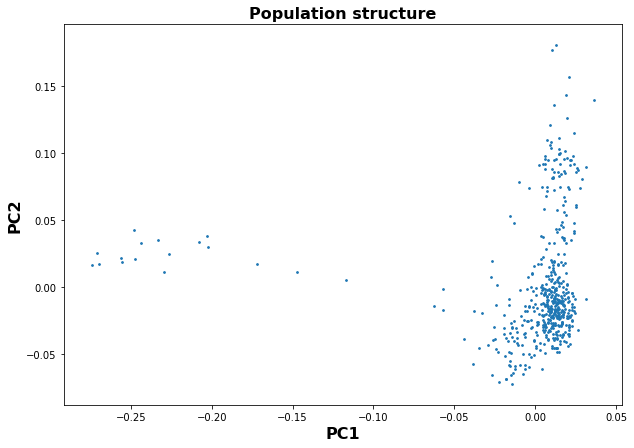

In [17]:
#make a scatter plot of PC1 vs PC2
plt.figure(figsize=(10, 7))
plt.scatter(ppmi_pca.PC1, ppmi_pca.PC2.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)
plt.show()

and PC2 vs PC3

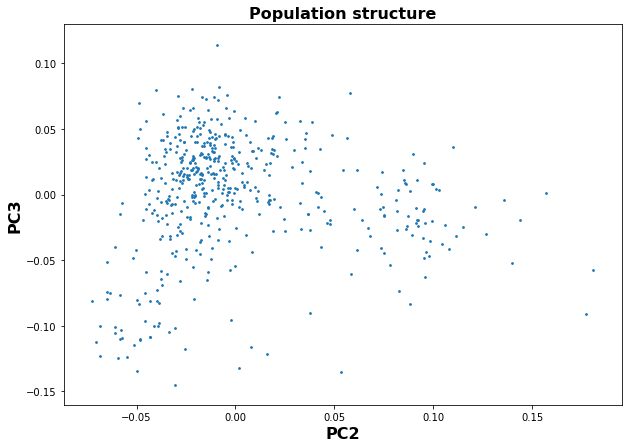

In [18]:
#make a scatter plot of PC2 vs PC3
plt.figure(figsize=(10, 7))
plt.scatter(ppmi_pca.PC2, ppmi_pca.PC3.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)
plt.show()

Now let's color subjects by population of origin. 

Such information is available in the Demographics file. So, we load the corresponding file and merge the Demographics file with the DataFrame storing PC values.

In [20]:
demo_fn = "../../data/patient_docs/Screening___Demographics.csv"
demo = pd.read_csv(demo_fn)
demo.head(n=10)

,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,SIGNCNST,CONSNTDT,APPRDX,CURRENT_APPRDX,P3GRP,...,PRJENRDT,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV
0,224392801,V,3400,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,07/2010,60.0,NaN,NaN,NaN,NaN,06/2010,2010-12-17 13:58:57.0,NaN,07/2010
1,224394301,V,3401,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:09:56.0,NaN,07/2010
2,224398401,V,3402,CONSENT,SCREEN,1.0,06/2010,3.0,3.0,NaN,...,10/2011,1.0,NaN,NaN,NaN,NaN,06/2010,2011-09-27 15:12:25.0,NaN,07/2010
3,224400201,V,3403,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:35:45.0,NaN,07/2010
4,224718101,V,3404,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 12:00:48.0,NaN,07/2010
5,232499401,S,3405,CONSENT,SCREEN,1.0,07/2010,2.0,2.0,NaN,...,07/2010,1.0,NaN,NaN,NaN,NaN,07/2010,2020-01-13 15:16:51.0,NaN,07/2010
6,232689201,V,3406,CONSENT,SCREEN,1.0,07/2010,1.0,1.0,NaN,...,08/2010,1.0,NaN,NaN,NaN,NaN,07/2010,2010-07-22 15:32:00.0,NaN,07/2010
7,241547001,V,3407,CONSENT,SCREEN,1.0,08/2010,1.0,1.0,NaN,...,09/2010,1.0,NaN,NaN,NaN,NaN,08/2010,2010-08-31 16:04:55.0,NaN,08/2010
8,243852101,V,3100,CONSENT,SCREEN,1.0,09/2010,2.0,2.0,NaN,...,10/2010,1.0,NaN,NaN,NaN,NaN,09/2010,2010-09-13 15:05:45.0,NaN,12/2010
9,244478101,V,3150,CONSENT,SCREEN,1.0,09/2010,1.0,1.0,NaN,...,11/2010,99.0,NaN,NaN,NaN,NaN,09/2010,2010-09-15 18:21:11.0,NaN,11/2010


Each subjects has a binary vector, which identifies the population(s) of origin of the individual.
We can exploit such information, by adding an additional column to the DataFrame, storing the subjects' popultaion.

In [21]:
pop_info = demo.iloc[:,12:19]
pop_info["PATNO"] = demo.iloc[:,2].tolist()
pops = list()
popDict = {0:"Hispanic/Latino", 1:"Indian/Alaska", 2:"Asian", 3:"Black/African American", 4:"Hawaiian/Other Pacif",
           5:"White", 6:"Race not specified"}
try:
    for i in range(len(pop_info.index)):
        patPop = pop_info.iloc[i,:7].tolist()
        if(sum(patPop) > 1):
            pops.append("More than one race")
        elif(sum(patPop) == 0 or np.all(np.isnan(patPop))):
            pops.append("Race not specified")
        else:
            j = np.where(np.array(patPop) == 1)
            pops.append(popDict[int(j[0])])
            
except Exception as e:
    raise e
    
demo["POPULATION"] = pops
demo.head()

,REC_ID,F_STATUS,PATNO,EVENT_ID,PAG_NAME,SIGNCNST,CONSNTDT,APPRDX,CURRENT_APPRDX,P3GRP,...,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV,POPULATION
0,224392801,V,3400,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,60.0,NaN,NaN,NaN,NaN,06/2010,2010-12-17 13:58:57.0,NaN,07/2010,White
1,224394301,V,3401,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:09:56.0,NaN,07/2010,White
2,224398401,V,3402,CONSENT,SCREEN,1.0,06/2010,3.0,3.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2011-09-27 15:12:25.0,NaN,07/2010,White
3,224400201,V,3403,CONSENT,SCREEN,1.0,06/2010,1.0,1.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 11:35:45.0,NaN,07/2010,White
4,224718101,V,3404,CONSENT,SCREEN,1.0,06/2010,2.0,2.0,NaN,...,1.0,NaN,NaN,NaN,NaN,06/2010,2010-07-20 12:00:48.0,NaN,07/2010,White


In [22]:
# merge demographics with PCs
ppmi_pca = ppmi_pca.merge(demo, left_on=['IID'], right_on=['PATNO'])
ppmi_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,REFERRAL,DECLINED,RSNDEC,EXCLUDED,RSNEXC,ORIG_ENTRY,LAST_UPDATE,QUERY,SITE_APRV,POPULATION
0,3000,3000,0.009711,-0.018291,-0.006058,0.002939,0.065272,-0.001394,-0.011362,-0.058289,...,31.0,NaN,NaN,NaN,NaN,01/2011,2011-01-19 15:44:58.0,NaN,01/2011,White
1,3001,3001,0.010701,-0.009840,0.015925,0.008439,-0.036720,0.041435,-0.045318,-0.012589,...,60.0,NaN,NaN,NaN,NaN,02/2011,2011-02-10 13:43:30.0,NaN,03/2011,White
2,3002,3002,0.010392,0.081568,-0.026678,-0.014991,-0.002337,-0.025038,-0.002785,0.012703,...,1.0,NaN,NaN,NaN,NaN,03/2011,2020-04-01 17:33:42.0,NaN,03/2011,White
3,3004,3004,0.015014,-0.023698,0.014627,-0.019912,-0.011551,0.021895,0.006360,-0.115199,...,99.0,NaN,NaN,NaN,NaN,03/2011,2011-03-30 14:43:13.0,NaN,03/2011,White
4,3006,3006,0.014774,-0.009399,0.057317,0.080115,0.042520,0.007801,-0.036297,-0.036565,...,1.0,NaN,NaN,NaN,NaN,03/2011,2020-04-22 09:14:39.0,NaN,03/2011,White
5,3008,3008,0.006309,-0.013975,-0.009787,-0.061537,0.021103,0.052570,0.031477,0.032635,...,4.0,NaN,NaN,NaN,NaN,05/2011,2013-10-31 14:28:09.0,NaN,05/2011,White
6,3009,3009,-0.269521,0.017724,0.024009,0.013818,0.015107,-0.027086,-0.049051,-0.036173,...,4.0,NaN,NaN,NaN,NaN,05/2011,2011-05-31 13:01:14.0,NaN,05/2011,Black/African American
7,3011,3011,0.016520,0.037783,0.017967,0.000313,0.043446,-0.031521,-0.000006,-0.016177,...,1.0,NaN,NaN,NaN,NaN,06/2011,2011-07-22 16:39:28.0,NaN,06/2011,White
8,3012,3012,-0.002101,0.009939,0.005402,0.012389,-0.009710,0.063923,0.060988,0.039166,...,1.0,NaN,NaN,NaN,NaN,10/2011,2011-10-12 13:48:43.0,NaN,10/2011,White
9,3016,3016,0.009412,-0.032344,-0.008212,-0.068398,-0.014028,-0.024512,-0.010251,0.074329,...,4.0,NaN,NaN,NaN,NaN,01/2012,2012-01-12 13:19:24.0,NaN,01/2012,White


We can now plot the population structure, by coloring the subjects by population(s) of origin. 

Text(0, 0.5, 'PC2')

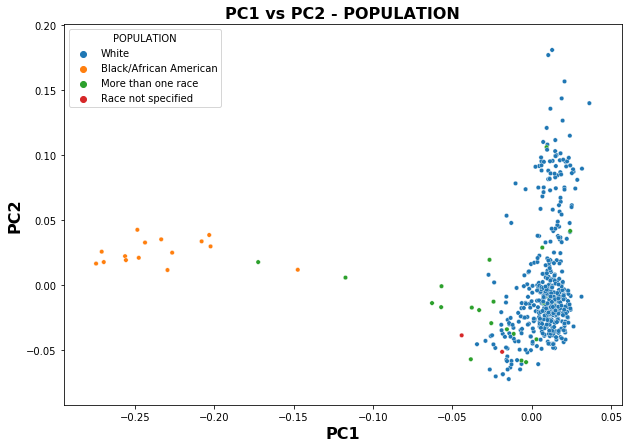

In [23]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='POPULATION', data=ppmi_pca, s=20)
plt.title('PC1 vs PC2 - POPULATION', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

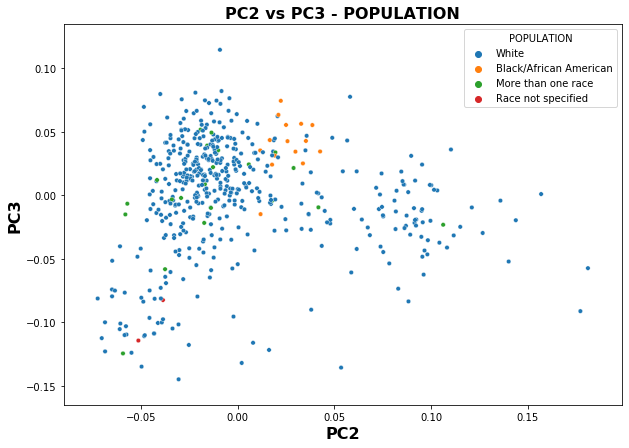

In [24]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC2', y='PC3', hue='POPULATION', data=ppmi_pca, s=20)
plt.title('PC2 vs PC3 - POPULATION', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)

To avoid potential bias introduced by population stratification during SNP-trait associations, we keep only those subjects with European ancestry.

In [25]:
eu_subjs = "../../data/genotyping/eu_subjs.txt"
ppmi_pca[ppmi_pca['POPULATION'] == "White"].iloc[:, 0:2].to_csv(eu_subjs, header=False, index=False, sep=" ")

We keep 469 subjects out of the original 508 individuals which passed QC steps.

Now, let's retrieve data regarding those 469 individuals with PLINK.

In [26]:
ppmi_eu_fn = "../../data/genotyping/PPMI_eu"
!plink --bfile {ppmi_merge_fn} --keep {eu_subjs} --make-bed --out {ppmi_eu_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_merge_subjQC_snpQC
  --keep ../../data/genotyping/eu_subjs.txt
  --make-bed
  --out ../../data/genotyping/PPMI_eu

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
508 people (341 males, 167 females) loaded from .fam.
--keep: 469 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 469 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.99666.
128812 variants and 469 people pass filte

Let's now explore the new population structure. As done before, to do this we compute the first 20 PCs. Then we plot PC1 vs PC2.

In [27]:
!plink --bfile {ppmi_eu_fn} --pca 20 --out {ppmi_eu_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu
  --out ../../data/genotyping/PPMI_eu
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
469 people (317 males, 152 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 469 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.99666.
128812 variants and 469 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Results saved to ../../data

In [28]:
ppmi_eu_pca = pd.read_csv(".".join([ppmi_eu_fn, "eigenvec"]), header=None, sep=" ")

# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
    
ppmi_eu_pca.columns = cnames
ppmi_eu_pca.head(n=15)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,3000,3000,0.018854,-0.005008,0.011334,0.066908,-0.002770,-0.019497,0.046207,-0.027001,...,-0.024146,-0.042162,0.018071,0.016654,-0.066501,-0.030358,-0.123226,0.072934,0.020239,-0.057093
1,3001,3001,0.011909,0.015442,0.013930,-0.037301,0.044462,-0.040237,0.019690,-0.047053,...,0.072236,-0.086521,0.012379,-0.043506,-0.051063,0.031440,0.015098,0.067920,-0.033440,0.032069
2,3002,3002,-0.080994,-0.030809,-0.021750,0.001921,-0.026049,-0.001750,-0.007024,0.014578,...,0.021777,0.010728,0.005821,-0.020620,-0.007211,-0.093209,-0.002782,-0.011159,-0.097739,-0.031718
3,3004,3004,0.023154,0.020064,-0.017455,-0.007909,0.029905,0.004181,0.122095,-0.020071,...,-0.038116,0.019648,-0.004582,0.080189,0.011660,-0.079753,-0.051499,-0.022194,-0.045953,-0.082702
4,3006,3006,0.006119,0.058869,0.090656,0.026587,0.004081,-0.038994,0.027686,-0.007014,...,-0.016670,0.005865,-0.009348,-0.001676,-0.026276,0.019836,-0.036629,0.021271,-0.047634,-0.034869
5,3008,3008,0.014923,-0.010042,-0.064513,0.032305,0.048736,0.041178,-0.021142,0.019931,...,0.067026,0.094160,-0.060492,0.119024,0.021081,0.055867,0.034755,0.040284,0.004602,0.056794
6,3011,3011,-0.041732,0.021910,0.010767,0.034337,-0.030231,-0.002327,0.031450,0.011884,...,0.011786,0.054110,-0.013969,0.029872,0.003754,0.062488,-0.065327,-0.057023,0.003137,-0.023686
7,3012,3012,-0.003170,-0.008274,0.012462,-0.002970,0.064221,0.069094,-0.040807,0.009334,...,0.017475,-0.014561,-0.000264,0.007107,0.039067,0.006688,0.035252,0.051168,0.039601,0.025037
8,3016,3016,0.032607,-0.002418,-0.076435,-0.005118,-0.028728,-0.016004,-0.072763,-0.035946,...,0.092994,-0.015704,-0.075301,0.016479,0.067569,-0.003016,0.024825,-0.053475,-0.008635,0.028358
9,3018,3018,0.020531,0.001566,0.070823,-0.046035,-0.062403,0.042329,-0.006991,0.037464,...,-0.029556,-0.048105,0.082758,0.039139,0.043450,0.100140,0.053628,0.026637,-0.033565,-0.028879


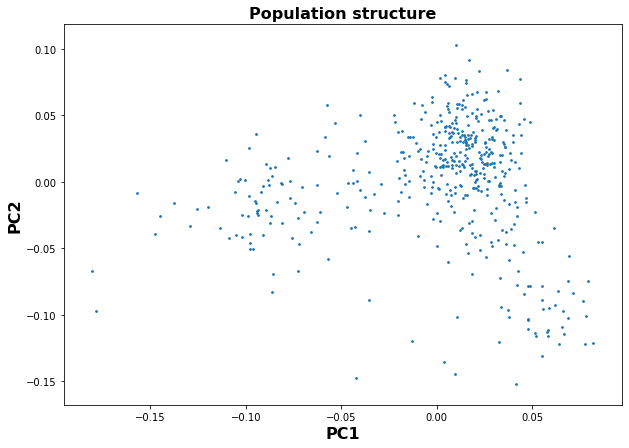

In [29]:
#make a scatter plot of PC1 vs PC2
plt.figure(figsize=(10, 7))
plt.scatter(ppmi_eu_pca.PC1, ppmi_eu_pca.PC2.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)
plt.show()

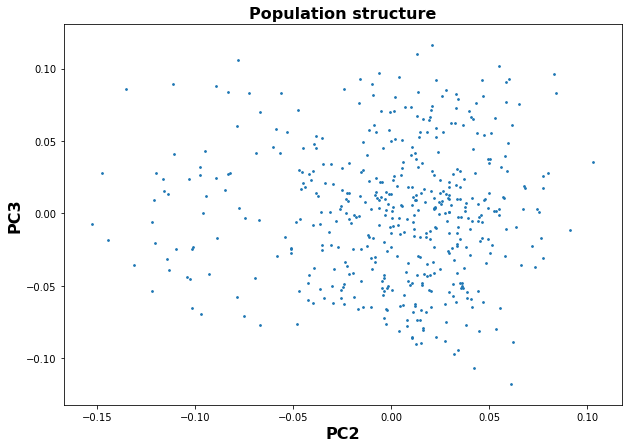

In [30]:
#and of PC2 vs PC3
plt.figure(figsize=(10, 7))
plt.scatter(ppmi_eu_pca.PC2, ppmi_eu_pca.PC3.values, s=3)
plt.title('Population structure', fontweight="bold", fontsize=16)
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)
plt.show()

We can explore how the population is distributed with respect to their enrollment category, i.e. wether they are Healthy controls (HCs), Parkinson's Disease patients (PD) or Subjects With Evidences of Dopamine Deficiency (SWEDD).

First, let's retrieve the enrollment category information for the individuals with European ancestry from the patient status file.

In [31]:
status_fn = "../../data/patient_docs/Patient_Status.csv"
status = pd.read_csv(status_fn)
status = status[status["PATNO"].isin(ppmi_eu_pca.iloc[:, 1].tolist())].reset_index(drop=True)
status.head()

,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013


And merge the PCs DataFrame with enrollment information.

In [32]:
ppmi_eu_pca = ppmi_eu_pca.merge(status, left_on=["IID"], right_on=["PATNO"])
ppmi_eu_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,3000,0.018854,-0.005008,0.011334,0.066908,-0.002770,-0.019497,0.046207,-0.027001,...,0.020239,-0.057093,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,3001,0.011909,0.015442,0.013930,-0.037301,0.044462,-0.040237,0.019690,-0.047053,...,-0.033440,0.032069,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,3002,-0.080994,-0.030809,-0.021750,0.001921,-0.026049,-0.001750,-0.007024,0.014578,...,-0.097739,-0.031718,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,3004,0.023154,0.020064,-0.017455,-0.007909,0.029905,0.004181,0.122095,-0.020071,...,-0.045953,-0.082702,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,3006,0.006119,0.058869,0.090656,0.026587,0.004081,-0.038994,0.027686,-0.007014,...,-0.047634,-0.034869,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013
5,3008,3008,0.014923,-0.010042,-0.064513,0.032305,0.048736,0.041178,-0.021142,0.019931,...,0.004602,0.056794,3008,HC,HC,06/2011,HC,Enrolled,NaN,06/2011
6,3011,3011,-0.041732,0.021910,0.010767,0.034337,-0.030231,-0.002327,0.031450,0.011884,...,0.003137,-0.023686,3011,HC,HC,07/2011,HC,Withdrew,NaN,07/2014
7,3012,3012,-0.003170,-0.008274,0.012462,-0.002970,0.064221,0.069094,-0.040807,0.009334,...,0.039601,0.025037,3012,PD,PD,11/2011,PD,Enrolled,NaN,11/2011
8,3016,3016,0.032607,-0.002418,-0.076435,-0.005118,-0.028728,-0.016004,-0.072763,-0.035946,...,-0.008635,0.028358,3016,HC,HC,02/2012,HC,Enrolled,NaN,02/2012
9,3018,3018,0.020531,0.001566,0.070823,-0.046035,-0.062403,0.042329,-0.006991,0.037464,...,-0.033565,-0.028879,3018,PD,PD,04/2012,PD,Enrolled,NaN,04/2012


And plot the population structure, by coloring the dots by enrollment category.

Text(0, 0.5, 'PC2')

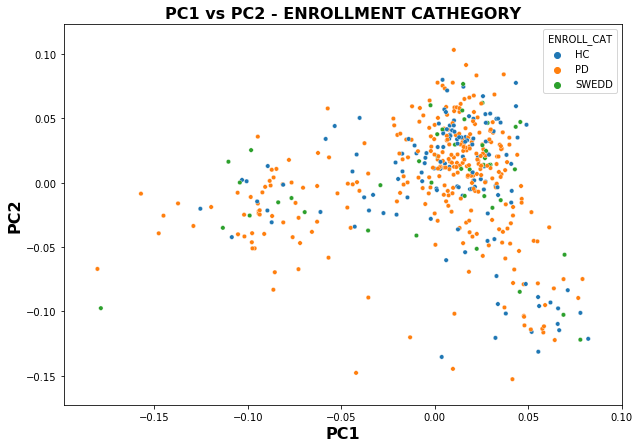

In [33]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='ENROLL_CAT', data=ppmi_eu_pca, s=20)
plt.title('PC1 vs PC2 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

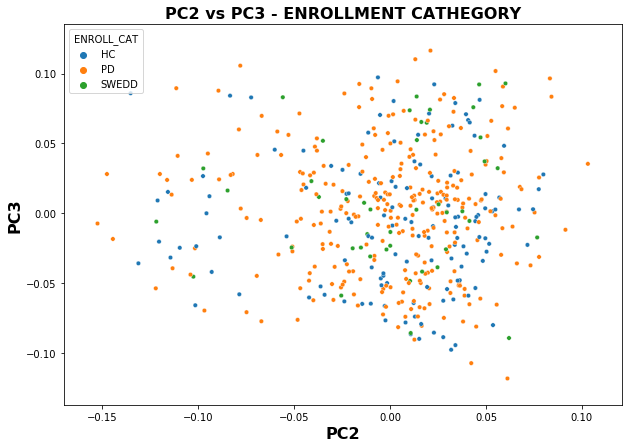

In [34]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC2', y='PC3', hue='ENROLL_CAT', data=ppmi_eu_pca, s=20)
plt.title('PC2 vs PC3 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)

As expected, there is no clear separation among the three categories.

In our study, we removed SWEDD patients. Since we searched for associations between SNPs and motor dysfuntion on PD, we decided to remove SWEDD patients because they are PD without dopamine deficiency, which is the main characteristic of PD motor dysfunctions. 

In [35]:
ppmi_eu_noswedd_fn = "_".join([ppmi_eu_fn, "noswedd"])
noswedd_fn = "../../data/genotyping/noswedd.txt"
ppmi_eu_pca[ppmi_eu_pca["ENROLL_CAT"] != "SWEDD"].iloc[:, 0:2].to_csv(noswedd_fn, sep=" ", index=False, header=False)

In [36]:
!plink --bfile {ppmi_eu_fn} --keep {noswedd_fn} --make-bed --out {ppmi_eu_noswedd_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu
  --keep ../../data/genotyping/noswedd.txt
  --make-bed
  --out ../../data/genotyping/PPMI_eu_noswedd

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
469 people (317 males, 152 females) loaded from .fam.
--keep: 425 people remaining.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 425 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate in remaining samples is 0.996669.
128812 variants and 425 people pass filte

After removing SWEDD subjects we remained with 425 individuals. Now let's explore again the population structure by coloring dots by enrollment cathegory

In [37]:
!plink --bfile {ppmi_eu_noswedd_fn} --pca 20 --out {ppmi_eu_noswedd_fn}

PLINK v1.90b6.12 64-bit (28 Oct 2019)          www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to ../../data/genotyping/PPMI_eu_noswedd.log.
Options in effect:
  --bfile ../../data/genotyping/PPMI_eu_noswedd
  --out ../../data/genotyping/PPMI_eu_noswedd
  --pca 20

16384 MB RAM detected; reserving 8192 MB for main workspace.
128812 variants loaded from .bim file.
425 people (289 males, 136 females) loaded from .fam.
Using up to 15 threads (change this with --threads).
Before main variant filters, 425 founders and 0 nonfounders present.
Calculating allele frequencies... 10111213141516171819202122232425262728293031323334353637383940414243444546474849505152535455565758596061626364656667686970717273747576777879808182838485868788899091929394959697989 done.
Total genotyping rate is 0.996669.
128812 variants and 425 people pass filters and QC.
Note: No phenotypes present.
Relationship matrix calculation complete.
--pca: Re

In [38]:
status = pd.read_csv(status_fn)

ppmi_eu_noswedd_pca = pd.read_csv(".".join([ppmi_eu_noswedd_fn, "eigenvec"]), sep=" ", header=None)
# assign FID and IID
cnames = ['FID','IID']
for i in range(1, 21):
    cnames.append("PC"+str(i))
ppmi_eu_noswedd_pca.columns = cnames

status = status[status["PATNO"].isin(ppmi_eu_noswedd_pca.iloc[:, 1].tolist())].reset_index(drop=True)
ppmi_eu_noswedd_pca = ppmi_eu_noswedd_pca.merge(status, left_on=["IID"], right_on=["PATNO"])
ppmi_eu_noswedd_pca.head(n=10)

,FID,IID,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,...,PC19,PC20,PATNO,RECRUITMENT_CAT,IMAGING_CAT,ENROLL_DATE,ENROLL_CAT,ENROLL_STATUS,DESCRP_CAT,STATUS_DATE
0,3000,3000,0.023384,0.001328,0.039375,0.063876,-0.001681,-0.034343,0.037898,0.019180,...,0.051771,0.060603,3000,HC,HC,02/2011,HC,Enrolled,NaN,02/2011
1,3001,3001,0.016262,0.015121,-0.003809,-0.046586,-0.044493,-0.062962,0.035246,-0.034485,...,-0.072890,-0.005280,3001,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
2,3002,3002,-0.082657,-0.034490,-0.021474,0.010143,0.027729,0.001859,-0.012908,0.000864,...,-0.069841,-0.000314,3002,PD,PD,03/2011,PD,Enrolled,NaN,03/2011
3,3004,3004,0.024364,0.031910,-0.007043,-0.000125,-0.047697,-0.048412,0.071974,0.034524,...,-0.026645,0.025348,3004,HC,HC,04/2011,HC,Enrolled,NaN,04/2011
4,3006,3006,0.004943,0.058706,0.101560,-0.012091,-0.001590,-0.046826,0.002213,-0.021489,...,-0.024590,0.021812,3006,PD,PD,05/2011,PD,Withdrew,NaN,10/2013
5,3008,3008,0.013609,-0.003114,-0.049586,0.051014,-0.045356,0.042686,-0.035074,-0.009928,...,-0.060949,-0.101880,3008,HC,HC,06/2011,HC,Enrolled,NaN,06/2011
6,3011,3011,-0.045445,0.024822,0.030438,0.026968,0.029164,-0.002245,-0.005380,0.000525,...,0.028343,0.004598,3011,HC,HC,07/2011,HC,Withdrew,NaN,07/2014
7,3012,3012,-0.006281,-0.014880,0.014264,-0.003137,-0.072666,0.060164,-0.022416,0.018638,...,0.013261,0.020655,3012,PD,PD,11/2011,PD,Enrolled,NaN,11/2011
8,3016,3016,0.039510,0.001308,-0.084473,0.027786,0.044725,-0.000008,-0.015730,-0.028161,...,-0.021731,-0.052503,3016,HC,HC,02/2012,HC,Enrolled,NaN,02/2012
9,3018,3018,0.016489,0.002115,0.066467,-0.082624,0.057401,0.064645,0.011232,-0.053308,...,-0.065909,0.036950,3018,PD,PD,04/2012,PD,Enrolled,NaN,04/2012


Text(0, 0.5, 'PC2')

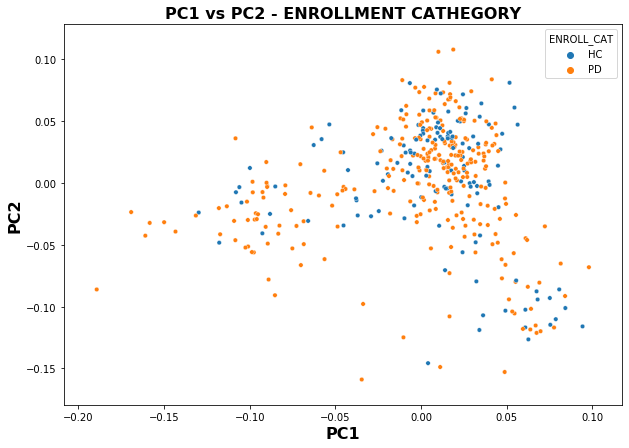

In [39]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC1', y='PC2', hue='ENROLL_CAT', data=ppmi_eu_noswedd_pca, s=20)
plt.title('PC1 vs PC2 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC1', fontweight="bold", fontsize=16)
plt.ylabel('PC2', fontweight="bold", fontsize=16)

Text(0, 0.5, 'PC3')

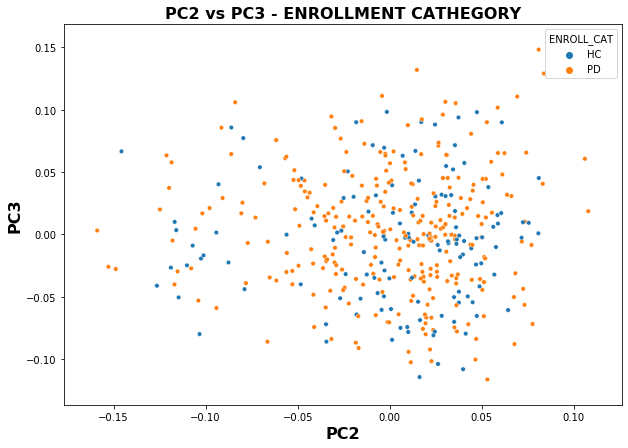

In [40]:
plt.figure(figsize=(10,7))
sns.scatterplot(x='PC2', y='PC3', hue='ENROLL_CAT', data=ppmi_eu_noswedd_pca, s=20)
plt.title('PC2 vs PC3 - ENROLLMENT CATHEGORY', fontsize=16, fontweight="bold")
plt.xlabel('PC2', fontweight="bold", fontsize=16)
plt.ylabel('PC3', fontweight="bold", fontsize=16)